# library

In [ ]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.impute import SimpleImputer
import zipfile
import io
from google.colab import files
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder

# import data

In [ ]:
url_base = "https://raw.githubusercontent.com/pierrebeguin/MRC/main/baseSimplifiee.csv"
response_0 = requests.get(url_base)
demographic = pd.read_csv(StringIO(response_0.text), sep=";")


url_1 = "https://github.com/pierrebeguin/MRC/raw/main/ascii-data-files_nida-ctn-0001.zip"
response_1 = requests.get(url_1)

with zipfile.ZipFile(io.BytesIO(response_1.content)) as z:
    with z.open('ascii-data-files_nida-ctn-0001/qs.csv') as f:
        qs_1 = pd.read_csv(f, sep=";", on_bad_lines='skip')


url_2 = "https://github.com/pierrebeguin/MRC/raw/main/ascii-data-files_nida-ctn-0002.zip"
response_2 = requests.get(url_2)

with zipfile.ZipFile(io.BytesIO(response_2.content)) as z:
    with z.open('ascii-data-files_nida-ctn-0002/qs.csv') as f:
        qs_2 = pd.read_csv(f, sep=";", on_bad_lines='skip')

# adam

In [ ]:
qs = pd.concat([qs_1, qs_2], ignore_index=True)
qs = qs[(qs['VISIT'] == 'BASELINE, ANY DAY PRIOR TO FIRST DOSE') & (qs['QSSCAT'] == 'FAMILY/SOCIAL RELATIONSHIPS')]

qs_clean = qs[['USUBJID', 'QSTESTCD', 'QSSCAT', 'QSORRES']]

pivot_table_qs = qs_clean.pivot_table(index='USUBJID',
                                    columns='QSTESTCD',
                                    values='QSORRES',
                                    aggfunc='sum',
                                    fill_value='nan')

pivot_table_qs.reset_index(inplace=True)

adam = pd.merge(demographic, pivot_table_qs, on='USUBJID', how='inner')
pd.set_option('display.max_columns', None)

### supprimer les SCREEN FAILURE
adam = adam[adam['ARM'] != "SCREEN FAILURE"]

# supprimer les STATUS = na
adam = adam[adam['STATUS'] != np.nan]

### supprimer les colonnes non-pertiente

colonne_a_sup = ['BRTHDTC', 'DMDTC', 'VAS1.fin', 'METHADONE.end', 'MORPHINE.end']

adam = adam.drop(columns= colonne_a_sup, errors='ignore')

# ranger les questions dans l'ordre
adam = adam[list(adam.columns[:26]) + sorted(adam.columns[26:], key=lambda x: int(''.join(filter(str.isdigit, x))))]

In [ ]:
# AGE
adam['AGE'] = adam['AGE'].apply(lambda x: np.floor(x) if pd.notna(x) else np.nan).astype('float64')

# HEIGHT
adam['HEIGHT'] = adam['HEIGHT'].replace(715, np.nan)

# RESP
adam['RESP'] = adam['RESP'].replace(1, np.nan)

# TEMP
adam['TEMP'] = adam['TEMP'].replace(999.9, np.nan)

# remplacer les 'nan' par na
adam = adam.replace('nan', np.nan)

# enlever le patent sans data
adam = adam[adam['USUBJID'] != "01_006253"]

In [ ]:
### Dictionnaire

#columns_to_factorize = ['GENDER', 'ARM', 'MARITAL', 'EMPLOYMENT', 'METHADONE.sc', 'MORPHINE.sc', 'STATUS', 'ADMISSION',
#                        'F1', 'F3', 'F4', 'F6', 'F7', 'F8', 'F9', 'F10', 'F18A', 'F18B', 'F19A', 'F19B', 'F20A', 'F20B', 'F21A', 'F21B', 'F22A', 'F22B', 'F23A', 'F23B',
#                        'F24A', 'F24B', 'F25A', 'F25B', 'F26A', 'F26B', 'F28A', 'F28B', 'F29A', 'F29B', 'F31', 'F32', 'F33', 'F34', 'F35', 'F37', 'F38']

#for column in columns_to_factorize:
#        adam[column], unique_values = pd.factorize(adam[column])
#        print(f"Mapping pour la colonne {column}:")
#        print(dict(enumerate(unique_values)))

In [ ]:
### Télécharger le fichier adam

#adam.to_csv('adam.csv', index=False, sep=";")
#files.download('adam.csv')

# graph : ARM x STATUS

<ipython-input-31-06508b06e22c>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = data_grouped.sum(axis=1)[i // 2]
<ipython-input-31-06508b06e22c>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = data_grouped.sum(axis=1)[i // 2]
<ipython-input-31-06508b06e22c>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cases = data_grouped.sum(axis=1)[i // 2]
<ipython-input-31-06508b06e22c>:19: FutureWarning

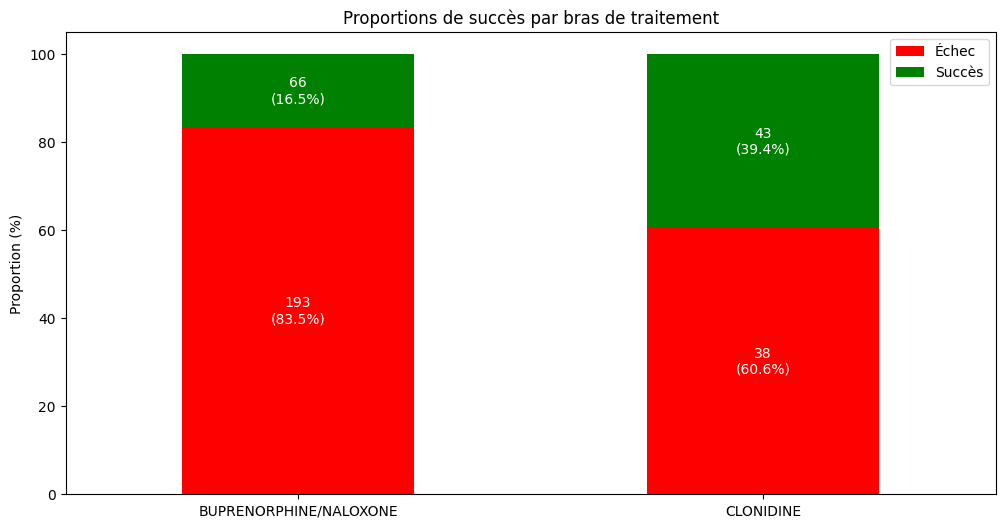

In [ ]:
# Grouper les données par molécule et status, puis compter les occurrences
data_grouped = adam.groupby(['ARM', 'STATUS']).size().unstack(fill_value=0)

# Calcul des proportions de succès et d'échec pour chaque molécule
proportions = data_grouped.div(data_grouped.sum(axis=1), axis=0) * 100

# Création du graphique en barres empilées
fig, ax = plt.subplots(figsize=(12, 6))
bars = proportions.plot(kind='bar', stacked=True, ax=ax, color=['red', 'green'])

# Ajout des annotations : valeurs absolues et proportions
for i, p in enumerate(bars.patches):
    width = p.get_width()      # Largeur de la barre
    height = p.get_height()    # Hauteur de la barre (proportion en %)
    x = p.get_x() + width / 2  # Position horizontale du texte
    y = p.get_y() + height / 2 # Position verticale du texte

    # Récupération des valeurs absolues
    total_cases = data_grouped.sum(axis=1)[i // 2]
    value = int(data_grouped.values[i // 2][i % 2])
    proportion = f"{height:.1f}%"

    # Annotation avec le nombre de cas et la proportion
    ax.text(x, y, f"{value}\n({proportion})", ha='center', va='center', fontsize=10, color='white')

# Personnalisation de l'axe des x avec étiquettes horizontales
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Personnalisation du graphique
plt.title("Proportions de succès par bras de traitement")
plt.xlabel('')
plt.ylabel("Proportion (%)")
plt.legend(["Échec", "Succès"], loc="upper right")
plt.show()

# Déterminer les corrélations :

In [ ]:
if 'STATUS' in adam.columns:

    # 1. Corrélation entre STATUS et les colonnes numériques (Pearson)
    # Filtrer les colonnes numériques
    numeric_columns = adam.select_dtypes(include=['number']).columns
    # Calculer la corrélation de Pearson entre STATUS (si numérique) et les autres colonnes numériques
    if 'STATUS' in numeric_columns:
        correlation_matrix = adam[numeric_columns].corr()
        status_corr = correlation_matrix['STATUS'].sort_values(ascending=False)
        print("Corrélations entre STATUS et les colonnes numériques :")
        print(status_corr)

    # 2. Test du Chi carré entre STATUS et les colonnes catégorielles
    # Filtrer les colonnes catégorielles
    categorical_columns = adam.select_dtypes(include=['object']).columns
    categorical_columns = [col for col in categorical_columns if col != 'STATUS']

    print("\nTest du Chi carré entre STATUS et les colonnes catégorielles :")
    for col in categorical_columns:
        # Calculer le test du Chi carré
        contingency_table = pd.crosstab(adam['STATUS'], adam[col])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"\nChi2 pour STATUS et {col}:")
        print(f"Chi2: {chi2}, p-value: {p_value}")
        if p_value < 0.05:
            print(f"Il y a une association significative entre STATUS et {col}.")
        else:
            print(f"Aucune association significative entre STATUS et {col}.")
else:
    print("La colonne 'STATUS' est absente dans le dataset.")

Corrélations entre STATUS et les colonnes numériques :
STATUS      1.000000
TEMP        0.158933
RESP        0.065348
WEIGHT      0.060775
PULSE       0.043312
DBP         0.038147
EDUCYRS     0.021701
VAS1.sc    -0.016839
HEIGHT     -0.028743
AGE        -0.044154
SBP        -0.076333
DSDY       -0.301221
VISITNUM   -0.538897
Name: STATUS, dtype: float64

Test du Chi carré entre STATUS et les colonnes catégorielles :

Chi2 pour STATUS et USUBJID:
Chi2: 339.99999999999994, p-value: 0.4744980158492091
Aucune association significative entre STATUS et USUBJID.

Chi2 pour STATUS et GENDER:
Chi2: 0.16027166456757275, p-value: 0.6889065249624726
Aucune association significative entre STATUS et GENDER.

Chi2 pour STATUS et ARM:
Chi2: 20.336809796544756, p-value: 6.49391924321529e-06
Il y a une association significative entre STATUS et ARM.

Chi2 pour STATUS et MARITAL:
Chi2: 5.000995147745672, p-value: 0.4157587497370631
Aucune association significative entre STATUS et MARITAL.

Chi2 pour STAT

# graph : barplot des corrélations entre STATUS et les données démographiques

<ipython-input-26-1c6362103be0>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Correlation', y='Column', data=sorted_corr_df, palette='coolwarm')


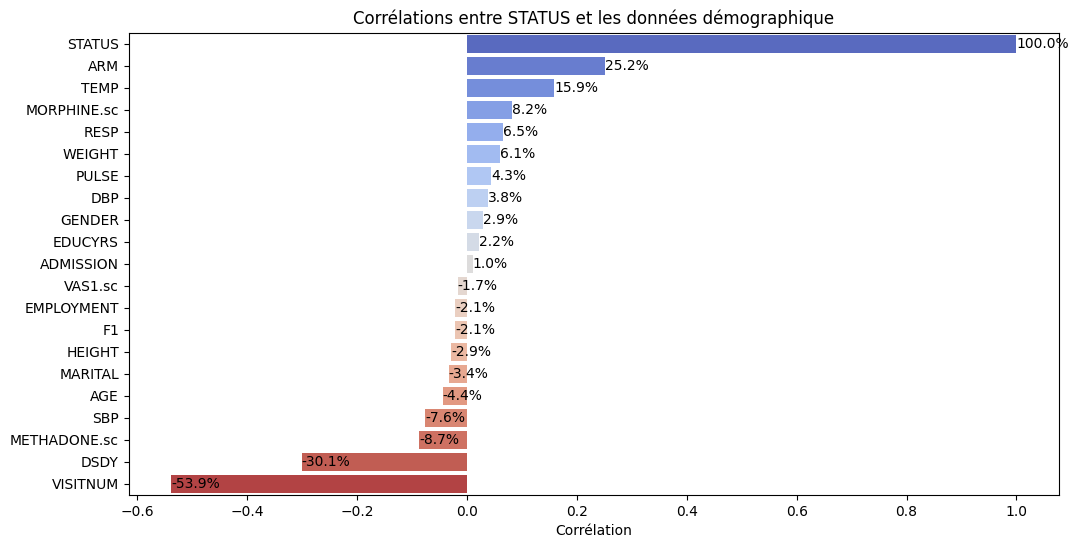

In [ ]:
# Sélection des colonnes catégorielles et numériques
categorical_cols = adam.iloc[:, 1:22].select_dtypes(include=['object', 'category']).columns
numerical_cols = adam.iloc[:, 1:22].select_dtypes(include=['number']).columns

# Encodage des colonnes catégorielles
encoded_adam = adam.copy()
le = LabelEncoder()

for col in categorical_cols:
    encoded_adam[col] = le.fit_transform(encoded_adam[col])

# Calcul des corrélations avec 'STATUS'
corr_data = encoded_adam.iloc[:, 1:22].apply(lambda col: encoded_adam['STATUS'].corr(col))
corr_df = corr_data.reset_index()
corr_df.columns = ['Column', 'Correlation']

# Trier les colonnes par corrélation pour l'affichage
sorted_corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Création du barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Correlation', y='Column', data=sorted_corr_df, palette='coolwarm')

# Ajouter les annotations des pourcentages dans l'ordre correct
for i, (column, correlation) in enumerate(zip(sorted_corr_df['Column'], sorted_corr_df['Correlation'])):
    plt.text(
        x=correlation,
        y=i,
        s=f"{correlation * 100:.1f}%",  # Convertir en pourcentage
        color='black',
        va='center'
    )

plt.title('Corrélations entre STATUS et les données démographique')
plt.xlabel('Corrélation')
plt.ylabel('')
plt.show()

# graph : barplot des corrélations entre STATUS et les questions

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
<ipython-input-9-53509d5c399a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Correlation', y='Column', data=sorted_corr_df, palette='coolwarm')


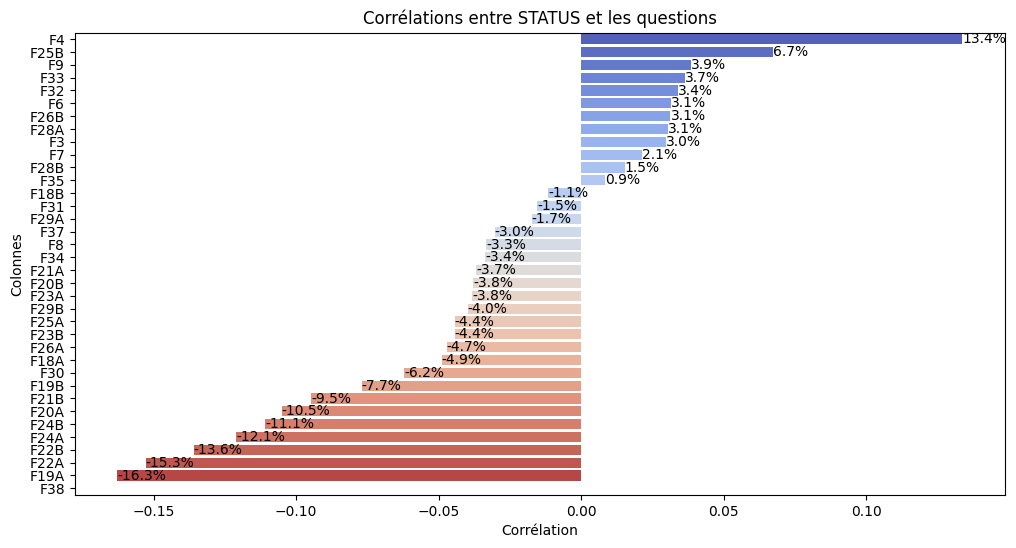

In [ ]:
# Sélection des colonnes catégorielles et numériques
categorical_cols = adam.iloc[:, 23:59].select_dtypes(include=['object', 'category']).columns
numerical_cols = adam.iloc[:, 23:59].select_dtypes(include=['number']).columns

# Encodage des colonnes catégorielles
encoded_adam = adam.copy()
le = LabelEncoder()

for col in categorical_cols:
    encoded_adam[col] = le.fit_transform(encoded_adam[col])

# Calcul des corrélations avec 'STATUS'
corr_data = encoded_adam.iloc[:, 23:59].apply(lambda col: encoded_adam['STATUS'].corr(col))
corr_df = corr_data.reset_index()
corr_df.columns = ['Column', 'Correlation']

# Trier les colonnes par corrélation pour l'affichage
sorted_corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Création du barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Correlation', y='Column', data=sorted_corr_df, palette='coolwarm')

# Ajouter les annotations des pourcentages dans l'ordre correct
for i, (column, correlation) in enumerate(zip(sorted_corr_df['Column'], sorted_corr_df['Correlation'])):
    plt.text(
        x=correlation,
        y=i,
        s=f"{correlation * 100:.1f}%",  # Convertir en pourcentage
        color='black',
        va='center'
    )

# Ajouter le titre et les étiquettes
plt.title('Corrélations entre STATUS et les questions')
plt.xlabel('Corrélation')
plt.ylabel('')
plt.show()

# Graph : Distribution des sexes par bras de traitement

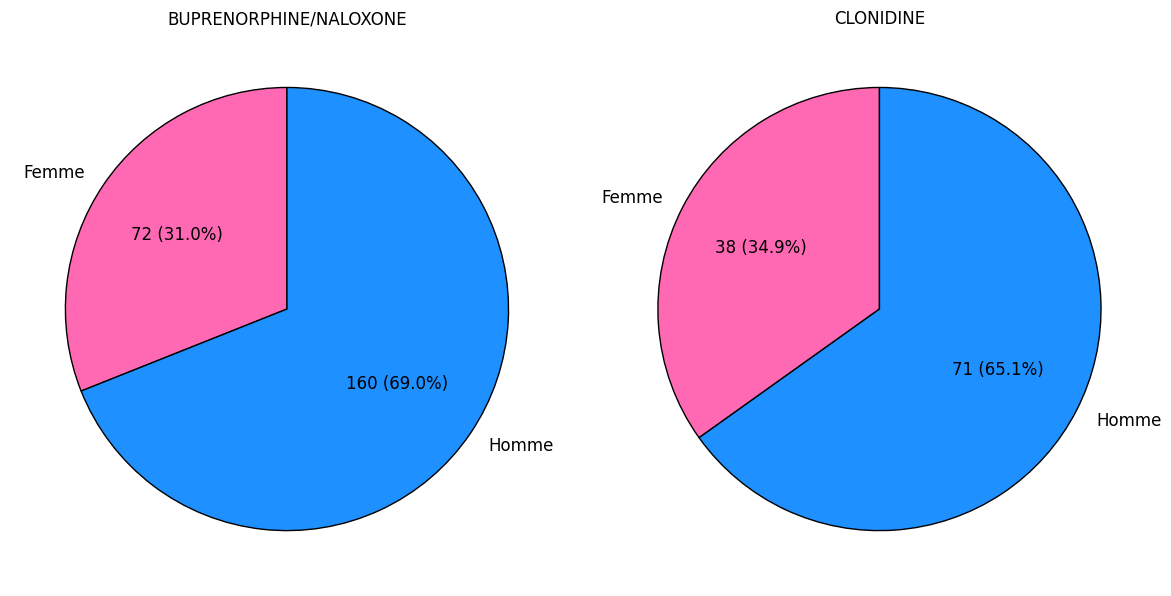

In [ ]:
# Compter le nombre de patients par sexe (GENDER) et bras de traitement (ARM)
gender_count_by_arm = adam.groupby(['ARM', 'GENDER']).size().unstack()

# Remplacer 'M' par 'Homme' et 'F' par 'Femme'
gender_count_by_arm = gender_count_by_arm.rename(columns={'M': 'Homme', 'F': 'Femme'})

# Définir les couleurs (rose pour Femme et bleu pour Homme)
colors = ['#FF69B4', '#1E90FF']  # Rose et bleu

# Créer une figure et un axe
fig, axes = plt.subplots(1, len(gender_count_by_arm), figsize=(12, 6))

# Si il n'y a qu'un seul bras de traitement, axes sera un tableau à un seul élément
if len(gender_count_by_arm) == 1:
    axes = [axes]

# Créer un pie chart pour chaque bras de traitement
for idx, (arm, counts) in enumerate(gender_count_by_arm.iterrows()):
    ax = axes[idx]

    # Calculer les pourcentages
    total = counts.sum()
    percentages = counts / total * 100

    # Dessiner le graphique en secteurs
    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, colors=colors, autopct='%1.1f%%', startangle=90,
                                      textprops={'size': 12}, wedgeprops={'edgecolor': 'black'})

    # Ajouter le nombre d'individus à côté des pourcentages
    for i, autotext in enumerate(autotexts):
        autotext.set_text(f"{counts.iloc[i]} ({autotext.get_text()})")

    # Personnaliser le titre
    ax.set_title(f'{arm}')
    ax.set_ylabel('')  # Enlever le label y car il est inutile

plt.tight_layout()
plt.show()

# graph : Répartition des âges par tranches de 5 ans

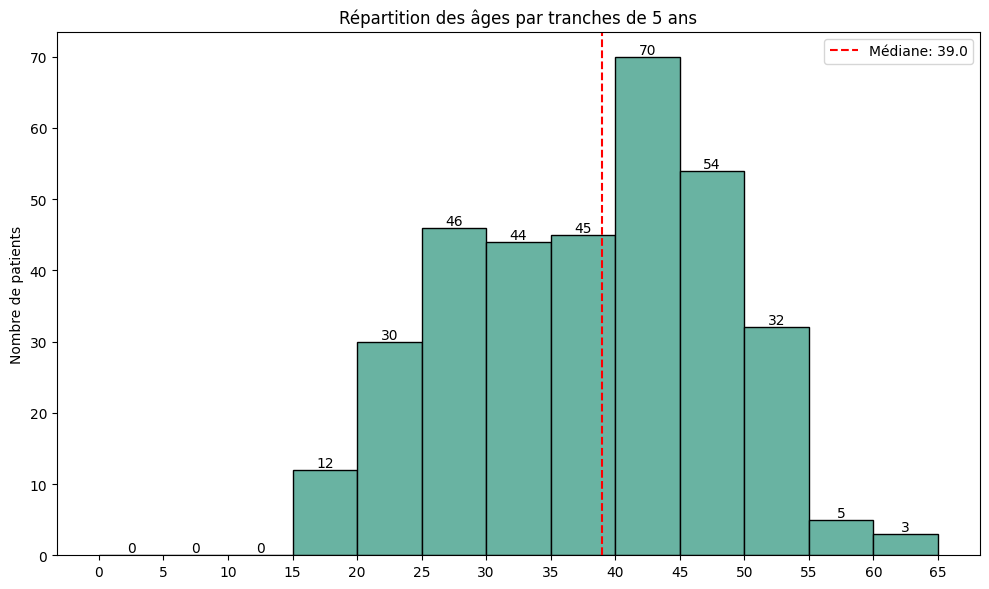

In [ ]:
# Créer des tranches d'âge de 5 ans
age_bins = range(0, int(adam['AGE'].max()) + 5, 5)  # Convert adam['AGE'].max() to an integer using int()

# Créer l'histogramme
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(adam['AGE'], bins=age_bins, edgecolor='black', color='#69b3a2')

# Ajouter un titre et des labels
plt.title('Répartition des âges par tranches de 5 ans')
plt.xlabel('')
plt.ylabel('Nombre de patients')

# Ajouter les étiquettes pour les tranches d'âge
plt.xticks(age_bins)

# Ajouter le nombre de patients au-dessus de chaque barre
for i in range(len(patches)):
    height = patches[i].get_height()  # Hauteur de chaque barre
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, height, str(int(height)),
             ha='center', va='bottom', fontsize=10)

median_age = adam['AGE'].median()
plt.axvline(x=median_age, color='red', linestyle='--', label=f'Médiane: {median_age}')
plt.legend()
plt.tight_layout()
plt.show()

# graph : Situation marital

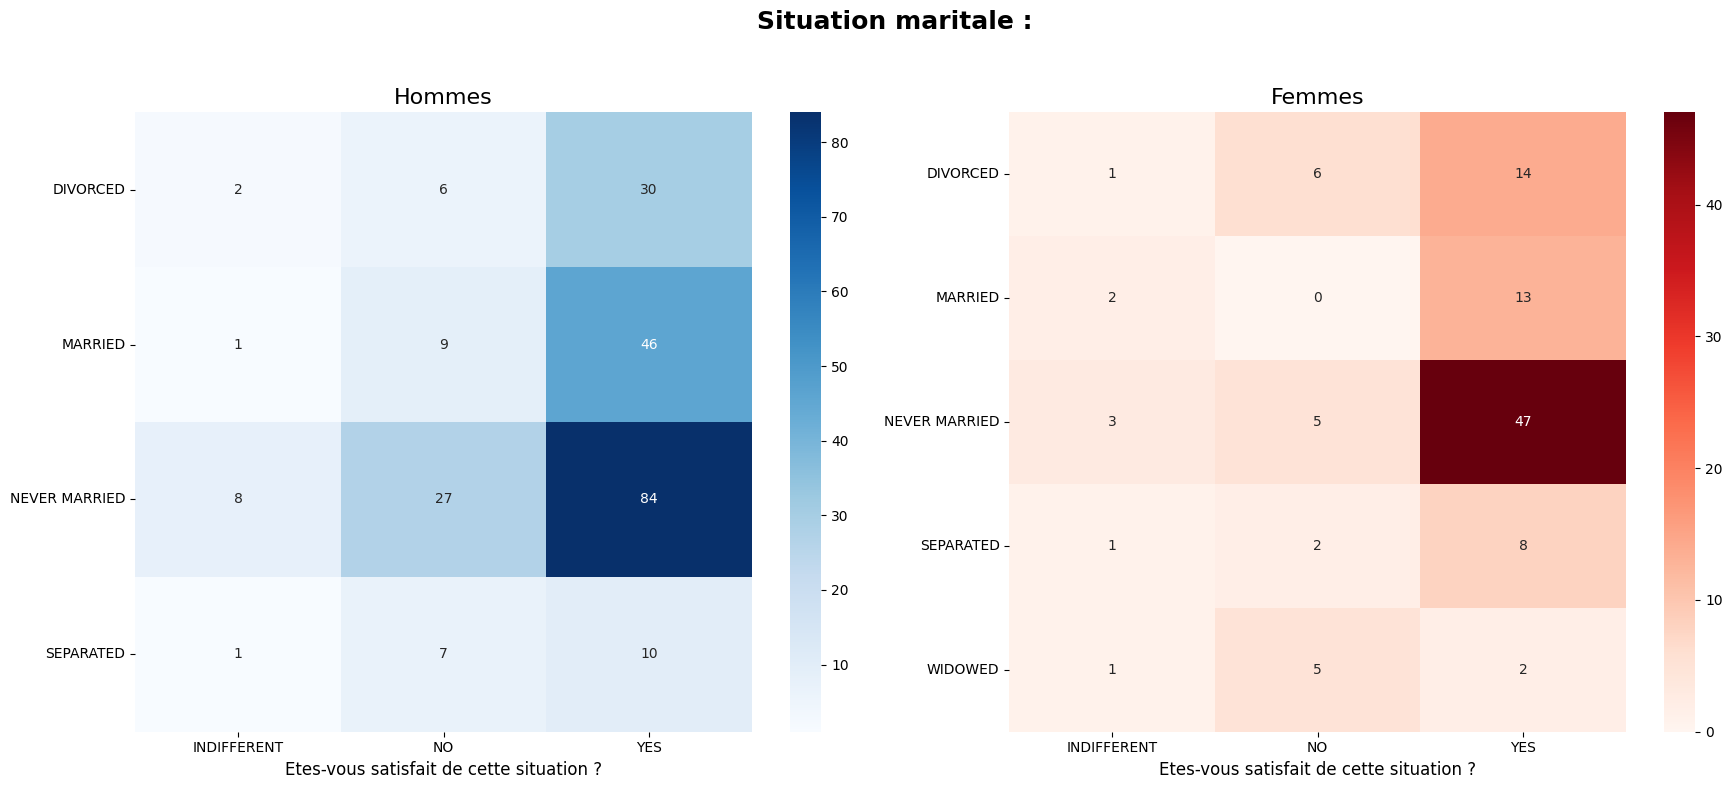

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer les données par sexe
men_data = adam[adam['GENDER'] == 'M']
women_data = adam[adam['GENDER'] == 'F']

# Créer des tables de contingence
contingency_men = pd.crosstab(men_data['F1'], men_data['F3'])
contingency_women = pd.crosstab(women_data['F1'], women_data['F3'])

# Créer les figures côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Ajouter un titre global
fig.suptitle('Situation maritale :', fontsize=18, fontweight='bold')

# Heatmap pour les hommes
sns.heatmap(contingency_men, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_title('Hommes', fontsize=16)
axes[0].set_xlabel('Etes-vous satisfait de cette situation ?', fontsize=12)
axes[0].set_ylabel('')  # Supprimer le titre de l'axe F1
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, horizontalalignment='right')

# Heatmap pour les femmes
sns.heatmap(contingency_women, annot=True, fmt='d', cmap='Reds', cbar=True, ax=axes[1])
axes[1].set_title('Femmes', fontsize=16)
axes[1].set_xlabel('Etes-vous satisfait de cette situation ?', fontsize=12)
axes[1].set_ylabel('')  # Supprimer le titre de l'axe F1
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, horizontalalignment='right')

# Ajustement et affichage
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de l'espace pour le titre global
plt.show()


# graph : Difficulté avec les proches

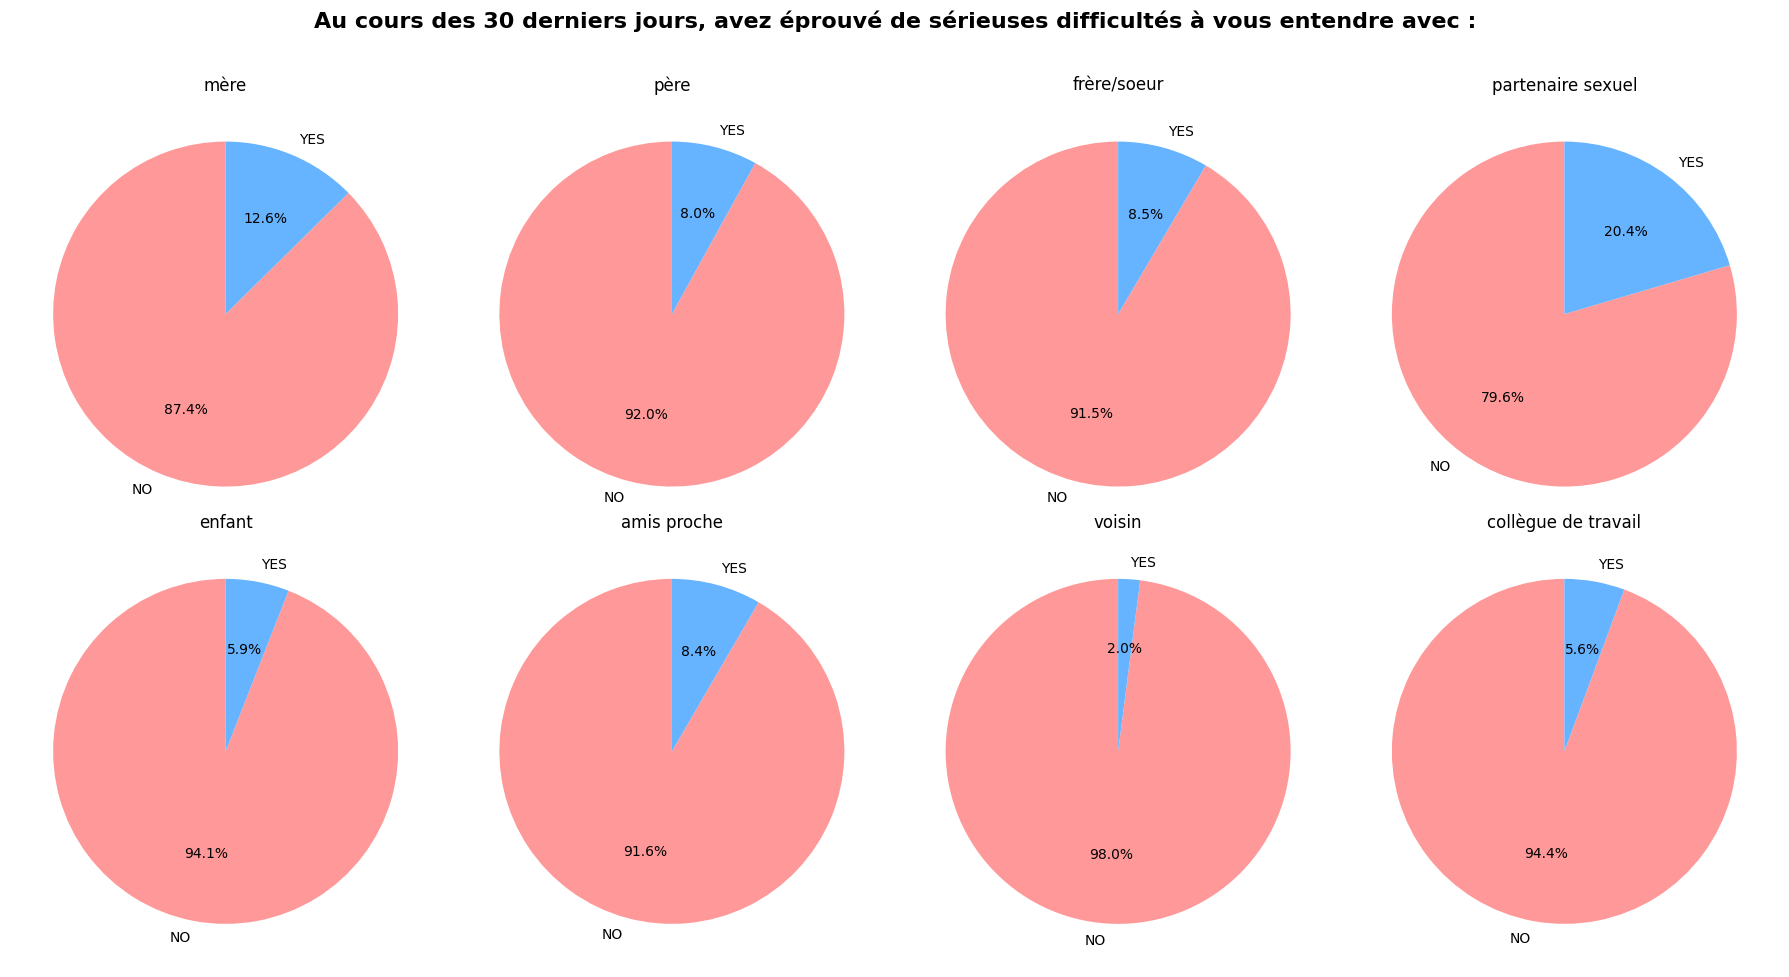

In [ ]:
# Créer une figure avec 8 sous-graphes (2 lignes et 4 colonnes)
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Liste des colonnes à utiliser pour les pie charts
columns = ['F18A', 'F19A', 'F20A', 'F21A', 'F22A', 'F24A', 'F25A', 'F26A']

# Liste des titres personnalisés pour chaque pie chart
titles = [
    'mère', 'père', 'frère/soeur',
    'partenaire sexuel', 'enfant', 'amis proche',
    'voisin', 'collègue de travail'
]

# Ajouter un titre global
fig.suptitle('Au cours des 30 derniers jours, avez éprouvé de sérieuses difficultés à vous entendre avec :',
             fontsize=16, fontweight='bold', ha='center')

# Boucle pour créer chaque pie chart
for i, column in enumerate(columns):
    # Calculer les valeurs de la pie chart pour la colonne courante
    value_counts = adam[column].value_counts()

    # Déterminer la position du subplot
    ax = axes[i // 4, i % 4]

    # Créer le pie chart
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

    # Ajouter un titre personnalisé à chaque pie chart
    ax.set_title(titles[i], fontsize=12)

# Ajuster l'espacement entre les graphiques
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de l'espace pour le titre global
plt.show()

# graph : histogramme des années d'études

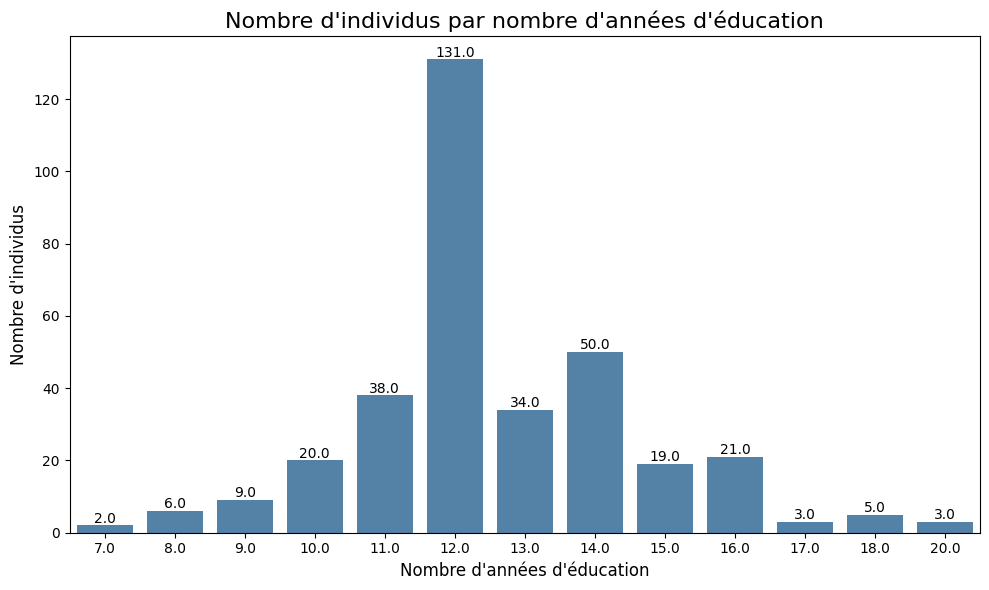

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EDUCYRS', data=adam, color='steelblue')

# Personnalisation du graphique
plt.title('Nombre d\'individus par nombre d\'années d\'éducation', fontsize=16)
plt.xlabel('Nombre d\'années d\'éducation', fontsize=12)
plt.ylabel('Nombre d\'individus', fontsize=12)

# Ajouter les labels au-dessus de chaque barre
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# graph

In [ ]:
adam[:2]

,USUBJID,GENDER,AGE,ARM,MARITAL,EDUCYRS,EMPLOYMENT,HEIGHT,WEIGHT,SBP,DBP,PULSE,RESP,TEMP,VAS1.sc,METHADONE.sc,MORPHINE.sc,VISITNUM,DSDY,STATUS,ADMISSION,F1,F10,F18A,F18B,F19A,F3,F4,F6,F7,F8,F9,F19B,F20A,F20B,F21A,F21B,F22A,F22B,F23A,F23B,F24A,F24B,F25A,F25B,F26A,F26B,F28A,F28B,F29A,F29B,F30,F31,F32,F33,F34,F35,F37,F38
0,01_000579,F,27.0,CLONIDINE,DIVORCED,14.0,UNEMPLOYED,67.0,130.0,132.0,80.0,72.0,20.0,98.8,38.0,NEGATIVE,POSITIVE,14.0,14.0,0.0,in-patient,DIVORCED,YES,YES,YES,NO,YES,WITH SEXUAL PARTNER ALONE,YES,NO,YES,FAMILY,NO,NO,NO,NO,NO,NO,NO,YES,NO,YES,NO,NO,NO,NO,NO,NO,YES,NO,YES,25,5,EXTREMELY,CONSIDERABLY,MODERATELY,MODERATELY,NO,NO
1,01_001362,F,41.0,CLONIDINE,NEVER MARRIED,13.0,UNEMPLOYED,58.0,179.0,114.0,76.0,72.0,18.0,98.0,16.0,POSITIVE,NEGATIVE,4.0,4.0,1.0,in-patient,NEVER MARRIED,YES,NO,NO,NO,YES,WITH CHILDREN ALONE,YES,NO,NO,ALONE,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,0,0,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT AT ALL,NO,NO


In [ ]:
adam.shape

(344, 59)